In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from IPython.display import display, display_html, HTML
import pprint

# Scikit-learn imports
from sklearn.metrics import (
    confusion_matrix, auc, roc_curve, roc_auc_score, 
    classification_report, ConfusionMatrixDisplay, 
    RocCurveDisplay, accuracy_score, precision_score, 
    recall_score, f1_score, make_scorer
)
from sklearn.model_selection import (
    train_test_split, cross_val_score, StratifiedShuffleSplit, 
    GridSearchCV, cross_val_predict, StratifiedKFold
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import compute_sample_weight
from sklearn.base import BaseEstimator, TransformerMixin

# Imbalanced-learn import
from imblearn.over_sampling import SMOTE

# Scipy import for hypothesis testing
from scipy.stats import chi2_contingency, f_oneway

# Set max columns and rows to display
pd.set_option('display.max_columns', 500)

# Ignore warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('data/two-years-recid.csv')

print(df.shape)
df.head()

(6114, 35)


,id,name,sex,dob,age,race,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_charge_degree,c_charge_desc,juv_fel_count,juv_misd_count,juv_other_count,priors_count,compas_screening_date,type_of_assessment,decile_score,score_text,v_type_of_assessment,v_decile_score,v_score_text,is_recid,r_case_number,r_offense_date,r_charge_degree,r_charge_desc,is_violent_recid,vr_case_number,vr_offense_date,vr_charge_degree,vr_charge_desc,two_year_recid
0,1,steven lux,Male,1953-06-15,62,Caucasian,2013-01-05 04:35:31,2013-01-07 03:18:03,13000208CF10A,2013-01-05,NaN,F,False Imprisonment,0,0,0,0,2013-01-05,Risk of Recidivism,1,Low,Risk of Violence,1,Low,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
1,2,andre small,Male,1987-10-01,28,African-American,2013-04-02 12:18:46,2013-04-04 07:54:22,13006354MM10A,2013-04-02,NaN,M,Battery,0,0,0,1,2013-04-03,Risk of Recidivism,3,Low,Risk of Violence,3,Low,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
2,3,willie gray,Male,1959-01-12,57,African-American,2014-10-31 12:02:01,2014-10-31 01:47:05,14040148MU10A,2014-10-30,NaN,M,DUI Level 0.15 Or Minor In Veh,0,0,0,8,2014-10-31,Risk of Recidivism,4,Low,Risk of Violence,2,Low,1,15043364TC20A,2015-07-23,(M2),Driving License Suspended,0,NaN,NaN,NaN,NaN,1
3,4,nickson marcellus,Male,1996-07-11,19,African-American,2014-01-23 03:19:30,2014-01-23 01:04:34,13017969CF10A,NaN,2014-01-23,F,arrest case no charge,0,1,0,1,2014-01-23,Risk of Recidivism,10,High,Risk of Violence,10,High,1,16000241MM20A,2016-01-04,(M1),Possess Cannabis/20 Grams Or Less,0,NaN,NaN,NaN,NaN,1
4,5,patria barnes,Female,1978-06-06,37,Other,2013-12-08 01:55:28,2013-12-09 02:00:59,13022717MM10A,2013-12-07,NaN,M,Battery,0,0,0,0,2013-12-09,Risk of Recidivism,1,Low,Risk of Violence,1,Low,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0


In [3]:
df.isna().sum()

id                          0
name                        0
sex                         0
dob                         0
age                         0
race                        0
c_jail_in                 260
c_jail_out                260
c_case_number              18
c_offense_date            959
c_arrest_date            5173
c_charge_degree             0
c_charge_desc              24
juv_fel_count               0
juv_misd_count              0
juv_other_count             0
priors_count                0
compas_screening_date       0
type_of_assessment          0
decile_score                0
score_text                  0
v_type_of_assessment        0
v_decile_score              0
v_score_text                0
is_recid                    0
r_case_number            3183
r_offense_date           3183
r_charge_degree          3183
r_charge_desc            3232
is_violent_recid            0
vr_case_number           5420
vr_offense_date          5420
vr_charge_degree         5420
vr_charge_

In [4]:
class PreprocessData(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.selected_columns = [
            "id", "name", "sex", "dob", "race",
            "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count",
            "c_case_number", "c_charge_degree", "c_charge_desc", "c_offense_date",
            "c_arrest_date", "c_jail_in", "is_recid"
        ]
    
    def fit(self, X, y=None):
        # This method doesn't need to do anything for this transformer
        return self
    
    def transform(self, X):
        # Make a copy of the dataframe to avoid modifying the original input
        df = X.copy()
        
        # Check if all selected columns exist in the dataframe
        missing_columns = [col for col in self.selected_columns if col not in df.columns]
        if missing_columns:
            raise KeyError(f"Columns {missing_columns} not found in the dataframe.")
        
        df = df[self.selected_columns]
        
        # Convert dates to datetime
        df['dob'] = pd.to_datetime(df['dob'])
        df['c_offense_date'] = pd.to_datetime(df['c_offense_date'])
        df['c_arrest_date'] = pd.to_datetime(df['c_arrest_date'])
        df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])

        # Age Calculation as an integer
        df['age_at_arrest'] = (df['c_jail_in'] - df['dob']).dt.days // 365
        
        # Remove rows where age_at_arrest is NaN
        df = df.dropna(subset=['age_at_arrest'])

        # Age group
        age_bins = [0, 24, 34, 44, 54, 100]
        age_labels = ['<25', '25-34', '35-44', '45-54', '55+']
        df['age_group'] = pd.cut(df['age_at_arrest'], bins=age_bins,
                                 labels=age_labels, right=False)

        # Replace c_charge_degree
        df['c_charge_degree'] = df['c_charge_degree'].str.replace('F', 'Felony')
        df['c_charge_degree'] = df['c_charge_degree'].str.replace('M', 'Misdemeanor')
        df['c_charge_degree'] = df['c_charge_degree'].fillna('Missing')

        # Drop unnecessary columns
        df = df.drop(['dob', 'c_case_number', 'c_charge_desc', 'c_offense_date', 'c_arrest_date', 'name',
                      'c_jail_in', 'age_at_arrest'], axis=1)
        
        # Calculate sample weights
        df['weights_race'] = compute_sample_weight(class_weight='balanced', y=df['race'])
        df['weights_sex'] = compute_sample_weight(class_weight='balanced', y=df['sex'])
        df['weights_age_group'] = compute_sample_weight(class_weight='balanced', y=df['age_group'])
        df['combined_weights_race_sex'] = df['weights_race'] + df['weights_sex']
        df['combined_weights_race_age_group'] = df['weights_race'] + df['weights_age_group']
        df['combined_weights_sex_age_group'] = df['weights_sex'] + df['weights_age_group']
        df['combined_weights'] = df['weights_race'] + df['weights_sex'] + df['weights_age_group']

        # Reset and set index because of rows removed
        df = df.reset_index(drop=True).set_index('id')

        return df


In [5]:
# apply the transformer to the dataframe
preprocessor = PreprocessData()

# Assuming df is your input dataframe
df_processed = preprocessor.transform(df)
df_processed

,sex,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,is_recid,age_group,weights_race,weights_sex,weights_age_group,combined_weights_race_sex,combined_weights_race_age_group,combined_weights_sex_age_group,combined_weights
id,,,,,,,,,,,,,,,,
1,Male,Caucasian,0,0,0,0,Felony,0,55+,0.483243,0.618816,3.279552,1.102059,3.762794,3.898368,4.381610
2,Male,African-American,0,0,0,1,Misdemeanor,0,25-34,0.326201,0.618816,0.579604,0.945017,0.905805,1.198420,1.524621
3,Male,African-American,0,0,0,8,Misdemeanor,1,55+,0.326201,0.618816,3.279552,0.945017,3.605753,3.898368,4.224569
4,Male,African-American,0,1,0,1,Felony,1,<25,0.326201,0.618816,0.691553,0.945017,1.017754,1.310370,1.636570
5,Female,Other,0,0,0,0,Misdemeanor,0,35-44,3.157497,2.604093,1.120383,5.761590,4.277880,3.724475,6.881973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6110,Male,African-American,0,0,0,1,Misdemeanor,0,25-34,0.326201,0.618816,0.579604,0.945017,0.905805,1.198420,1.524621
6111,Male,African-American,0,0,0,4,Misdemeanor,0,25-34,0.326201,0.618816,0.579604,0.945017,0.905805,1.198420,1.524621
6112,Female,Caucasian,0,0,0,0,Felony,0,25-34,0.483243,2.604093,0.579604,3.087335,1.062846,3.183696,3.666939


In [6]:
# Function to get privileged and unprivileged groups based on protected attribute
def get_groups(protected_attribute, protected_values):
    if protected_attribute == 'race':
        privileged_group = (protected_values == 'Caucasian')
        unprivileged_group = (protected_values == 'African-American')
    elif protected_attribute == 'sex':
        privileged_group = (protected_values == 'Male')
        unprivileged_group = (protected_values == 'Female')
    elif protected_attribute == 'age_group':
        privileged_group = (protected_values == '<25')
        unprivileged_group = (protected_values == '55+')
    else:
        raise ValueError(f"Protected attribute '{protected_attribute}' not recognized.")

    return privileged_group, unprivileged_group

# Function to calculate disparate impact
def calculate_disparate_impact(y_true, y_pred, protected_attribute, df):
    # Computed as the ratio of rate of favorable outcome for the unprivileged group to that of the privileged group.
    # The ideal value of this metric is 1.0 A value < 1 implies higher benefit for the privileged group and a value >1 implies a higher benefit for the unprivileged group.
    # Fairness for this metric is between 0.8 and 1.25
    
    """
    Calculates the Disparate Impact metric for fairness assessment.

    Parameters:
    - y_true: True labels or outcomes.
    - y_pred: Predicted probabilities or outcomes from a model.
    - protected_attribute: Name of the column in `df` that contains the protected attribute.
    - df: DataFrame containing the protected attribute values.

    Returns:
    - disparate_impact: Disparate Impact metric. NaN if there are no samples in one of the groups.
    """
    
    protected_values = df.loc[y_true.index, protected_attribute]
    
    privileged_group, unprivileged_group = get_groups(protected_attribute, protected_values)
    
    #if protected_attribute == 'race':
    #    privileged_group = (protected_values == 'Caucasian')
    #    unprivileged_group = (protected_values == 'African-American')
    #elif protected_attribute == 'sex':
    #    privileged_group = (protected_values == 'Male')
    #    unprivileged_group = (protected_values == 'Female')
    #elif protected_attribute == 'age_group':
    #    privileged_group = (protected_values == '<25')
    #    unprivileged_group = (protected_values == '55+')
    #else:
    #    raise ValueError(f"Unsupported protected attribute: {protected_attribute}")
    
    # Check if any samples belong to the privileged or unprivileged group
    if np.sum(privileged_group) == 0 or np.sum(unprivileged_group) == 0:
        return np.nan  # Return NaN if there are no samples in one of the groups
    
    # Calculate the selection rate for each group if they are non-empty
    privileged_selection_rate = y_pred[privileged_group].mean() if np.sum(privileged_group) > 0 else np.nan
    unprivileged_selection_rate = y_pred[unprivileged_group].mean() if np.sum(unprivileged_group) > 0 else np.nan
    
    # Disparate impact is the ratio of the unprivileged to privileged selection rates
    disparate_impact = unprivileged_selection_rate / privileged_selection_rate
    
    return disparate_impact

# Function to calculate equal opportunity
def calculate_equal_opportunity(y_true, y_pred, protected_attribute, df):
    # Metric computed as the difference of true positive rates between the unprivileged and the privileged groups. 
    # The ideal value is 0. A value of < 0 implies higher benefit for the privileged group and > 0 implies higher benefit for the unprivileged group.
    # Fairness for this metric is between -0.1 and 0.1
    
    """
    Calculates the Equal Opportunity metric for fairness assessment.

    Parameters:
    - y_true: True labels or outcomes.
    - y_pred: Predicted probabilities or outcomes from a model.
    - protected_attribute: Name of the column in `df` that contains the protected attribute.
    - df: DataFrame containing the protected attribute values.

    Returns:
    - equal_opportunity: Equal Opportunity metric. NaN if there are no samples in one of the groups.
    """
    
    # Use only the rows corresponding to the test set
    protected_values = df.loc[y_true.index, protected_attribute]
    
    # Define privileged and unprivileged groups based on the protected attribute
    if protected_attribute == 'race':
        privileged_group = (protected_values == 'Caucasian')
        unprivileged_group = (protected_values == 'African-American')
    elif protected_attribute == 'sex':
        privileged_group = (protected_values == 'Male')
        unprivileged_group = (protected_values == 'Female')
    elif protected_attribute == 'age_group':
        privileged_group = (protected_values == '<25')
        unprivileged_group = (protected_values == '55+')
    else:
        raise ValueError(f"Unsupported protected attribute: {protected_attribute}")
    
    # Calculate true positive rates (TPR) for each group
    tpr_privileged = ((y_pred == 1) & (y_true == 1) & privileged_group).sum() / (y_true[privileged_group] == 1).sum()
    tpr_unprivileged = ((y_pred == 1) & (y_true == 1) & unprivileged_group).sum() / (y_true[unprivileged_group] == 1).sum()
    
    # Equal opportunity difference
    equal_opportunity = tpr_unprivileged - tpr_privileged
    
    return equal_opportunity


In [28]:
# Split the data into features (X) and target (y)
X = df_processed.drop(columns=['is_recid', 'weights_race', 'weights_sex', 'weights_age_group', 'combined_weights_race_sex', 'combined_weights_race_age_group', 'combined_weights_sex_age_group', 'combined_weights'])
y = df_processed['is_recid']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Categorical and numerical columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Define preprocessing pipelines
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols)
    ]
)

# Define the pipeline
log_reg_with_weights = LogisticRegression(random_state=42, max_iter=1000)
pipe_with_weights = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', log_reg_with_weights)
])



# List of weight combinations to evaluate
weight_columns = ['weights_race', 'weights_sex', 'weights_age_group', 'combined_weights_race_sex', 'combined_weights_race_age_group', 'combined_weights_sex_age_group', 'combined_weights']
sensitive_feature = ['race','sex','age_group']


log_reg_with_weights = LogisticRegression(random_state=42, max_iter=1000)

#fit the pipeline with weights
pipe_with_weights = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', log_reg_with_weights)
])


equal_opportunity_with_weights = {}
accuracy_scores_with_weights = {}

# Example lists of sensitive features and weight columns
sensitive_features = ['sex', 'age_group', 'race']
weight_columns = ['weights_sex', 'weights_age_group', 'combined_weights_sex_age_group', 'weights_race',
                  'combined_weights_race_sex', 'combined_weights_race_age_group', 'combined_weights_sex_age_group', 'combined_weights']

for feature in sensitive_features:
    equal_opportunity_with_weights[feature] = {}
    accuracy_scores_with_weights[feature] = {}
    for weight in weight_columns:
        # Assuming you have a function calculate_disparate_impact defined elsewhere
        sample_weights = df_processed.loc[X_train.index, weight]
        pipe_with_weights.fit(X_train, y_train, classifier__sample_weight=sample_weights)
        
        ypred_with_weights = pipe_with_weights.predict(X_test)
        
        
        # Store the disparate impact value in the dictionary
        equal_opportunity_with_weights[feature][weight] = calculate_equal_opportunity(y_test,ypred_with_weights,feature,X_test)
        
        # Calculate accuracy score
        accuracy_scores_with_weights[feature][weight] = accuracy_score(y_test, ypred_with_weights)

# Print or use the disparate_impacts dictionary
pprint.pprint(equal_opportunity_with_weights)


log_reg_no_weights = LogisticRegression(random_state=42, max_iter=1000)

pipe_no_weights = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', log_reg_no_weights)
])

equal_opportunity_no_weights = {}
accuracy_scores_no_weights = {}

sensitive_features = ['sex', 'age_group', 'race']

for feature in sensitive_features:
    # Assuming you have a function calculate_disparate_impact defined elsewhere
    pipe_no_weights.fit(X_train, y_train)
    
    ypred_no_weights = pipe_no_weights.predict(X_test)
    
    
    # Store the disparate impact value in the dictionary
    equal_opportunity_no_weights[feature] = calculate_equal_opportunity(y_test,ypred_with_weights,feature,X_test)
    
    # Calculate accuracy score
    accuracy_scores_no_weights[feature]= accuracy_score(y_test, ypred_no_weights)

# Print or use the disparate_impacts dictionary
pprint.pprint(equal_opportunity_no_weights)

{'age_group': {'combined_weights': -0.231680236861584,
               'combined_weights_race_age_group': -0.25758697261287933,
               'combined_weights_race_sex': -0.02862077473476432,
               'combined_weights_sex_age_group': -0.18504811250925246,
               'weights_age_group': -0.22649888971132492,
               'weights_race': -0.08561559338761404,
               'weights_sex': -0.1633358006415001},
 'race': {'combined_weights': 0.27429467084639503,
          'combined_weights_race_age_group': 0.2591116818370661,
          'combined_weights_race_sex': 0.1954337727083884,
          'combined_weights_sex_age_group': 0.35961400460777276,
          'weights_age_group': 0.39385126713751556,
          'weights_race': 0.17471767949541106,
          'weights_sex': 0.2752766552101824},
 'sex': {'combined_weights': -0.3576958373532249,
         'combined_weights_race_age_group': -0.2831964609266537,
         'combined_weights_race_sex': -0.28032567004729747,
         'com

In [8]:
pprint.pprint(accuracy_scores_with_weights)

{'age_group': {'combined_weights': 0.677198975234842,
               'combined_weights_race_age_group': 0.672929120409906,
               'combined_weights_race_sex': 0.6686592655849701,
               'combined_weights_sex_age_group': 0.677198975234842,
               'weights_age_group': 0.6712211784799317,
               'weights_race': 0.6686592655849701,
               'weights_sex': 0.6737830913748932},
 'race': {'combined_weights': 0.677198975234842,
          'combined_weights_race_age_group': 0.672929120409906,
          'combined_weights_race_sex': 0.6686592655849701,
          'combined_weights_sex_age_group': 0.677198975234842,
          'weights_age_group': 0.6712211784799317,
          'weights_race': 0.6686592655849701,
          'weights_sex': 0.6737830913748932},
 'sex': {'combined_weights': 0.677198975234842,
         'combined_weights_race_age_group': 0.672929120409906,
         'combined_weights_race_sex': 0.6686592655849701,
         'combined_weights_sex_age_group

In [9]:
pprint.pprint(accuracy_scores_no_weights)

{'age_group': 0.6712211784799317,
 'race': 0.6712211784799317,
 'sex': 0.6712211784799317}


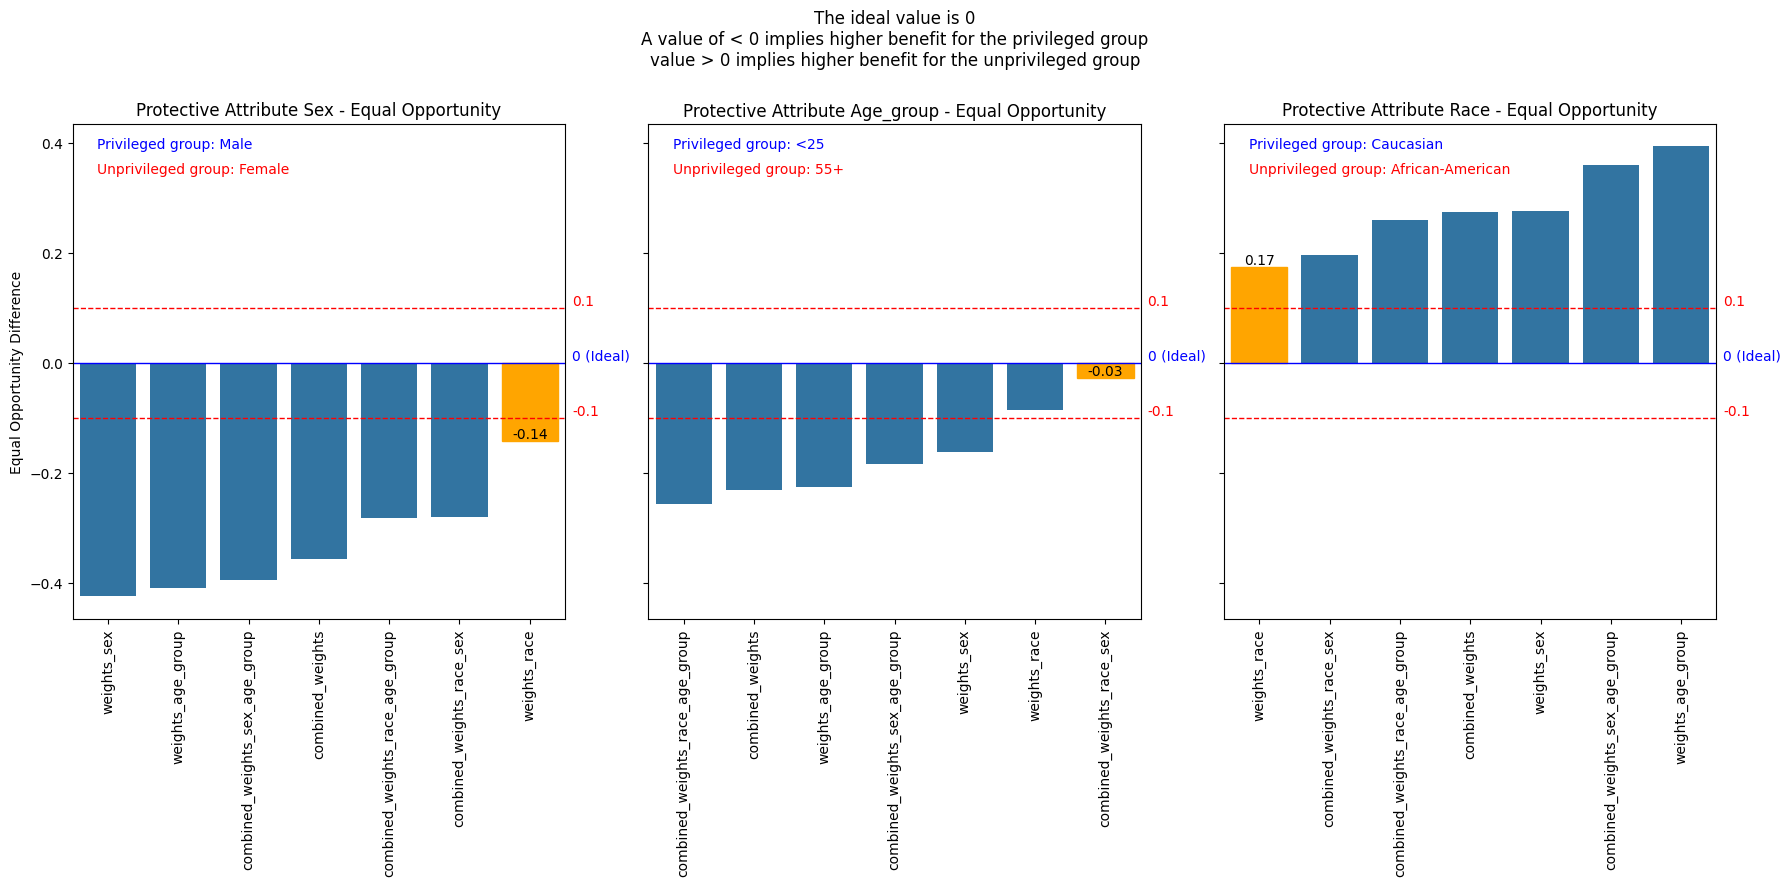

In [63]:
# Iterate over each key in data and create a subplot
fig, axs = plt.subplots(1, 3, figsize=(18, 9), sharey=True)

plt.suptitle("The ideal value is 0\n"
             "A value of < 0 implies higher benefit for the privileged group\n"
             "value > 0 implies higher benefit for the unprivileged group\n",
             fontsize=12, ha='center')


# Iterate over each key ('age_group', 'race', 'sex')
for idx, key in enumerate(equal_opportunity_with_weights.keys()):
    impacts = equal_opportunity_with_weights[key]
    
    # Step 1: Sort the dictionary by values
    sorted_impacts = dict(sorted(impacts.items(), key=lambda item: item[1]))

    # Step 2: Identify the bar closest to -0.1 or 0.1
    closest_value = None
    closest_distance = float('inf')
    closest_key = None

    for k, value in sorted_impacts.items():
        distance_to_neg = abs(-0.1 + value)
        distance_to_pos = abs(value - 0.1)
        if distance_to_neg < closest_distance:
            closest_distance = distance_to_neg
            closest_value = value
            closest_key = k
        if distance_to_pos < closest_distance:
            closest_distance = distance_to_pos
            closest_value = value
            closest_key = k

    # Step 3: Plot the bar chart with a different color for the closest bar
    bars = sns.barplot(ax=axs[idx], x=list(sorted_impacts.keys()), y=list(sorted_impacts.values()))

    # Change the color of the closest bar and add the value on top of it
    for bar, k in zip(bars.patches, sorted_impacts.keys()):
        if k == closest_key:
            bar.set_color('orange')
            height = bar.get_height()
            axs[idx].text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom', color='black')

    axs[idx].set_xticklabels(axs[idx].get_xticklabels(), rotation=90)
    axs[idx].set_ylabel('Equal Opportunity Difference')
    axs[idx].set_title(f'Protective Attribute {key.capitalize()} - Equal Opportunity')

    # Step 4: Draw interval lines between -0.1 and 0.1
    axs[idx].axhline(0.1, color='red', linestyle='--', linewidth=1)
    axs[idx].axhline(-0.1, color='red', linestyle='--', linewidth=1)
    axs[idx].axhline(0, color='blue', linestyle='-', linewidth=1)  # Add line for the ideal value 1.0

    # Step 5: Annotate the lines
    axs[idx].text(len(sorted_impacts) - 0.4, 0.1, '0.1', color='red', verticalalignment='bottom')
    axs[idx].text(len(sorted_impacts) - 0.4, -0.1, '-0.1', color='red', verticalalignment='bottom')
    axs[idx].text(len(sorted_impacts) - 0.4, 0, '0 (Ideal)', color='blue', verticalalignment='bottom')
    
    # Step 6: Add attribute-specific text
    if key in ['race', 'sex', 'age_group']:
        privileged_group_text = "Privileged group: Caucasian" if key == 'race' else "Privileged group: Male" if key == 'sex' else "Privileged group: <25"
        unprivileged_group_text = "Unprivileged group: African-American" if key == 'race' else "Unprivileged group: Female" if key == 'sex' else "Unprivileged group: 55+"
        
        axs[idx].text(0.05, 0.95, privileged_group_text, transform=axs[idx].transAxes, horizontalalignment='left', fontsize=10, color='blue')
        axs[idx].text(0.05, 0.9, unprivileged_group_text, transform=axs[idx].transAxes, horizontalalignment='left', fontsize=10, color='red')
    

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

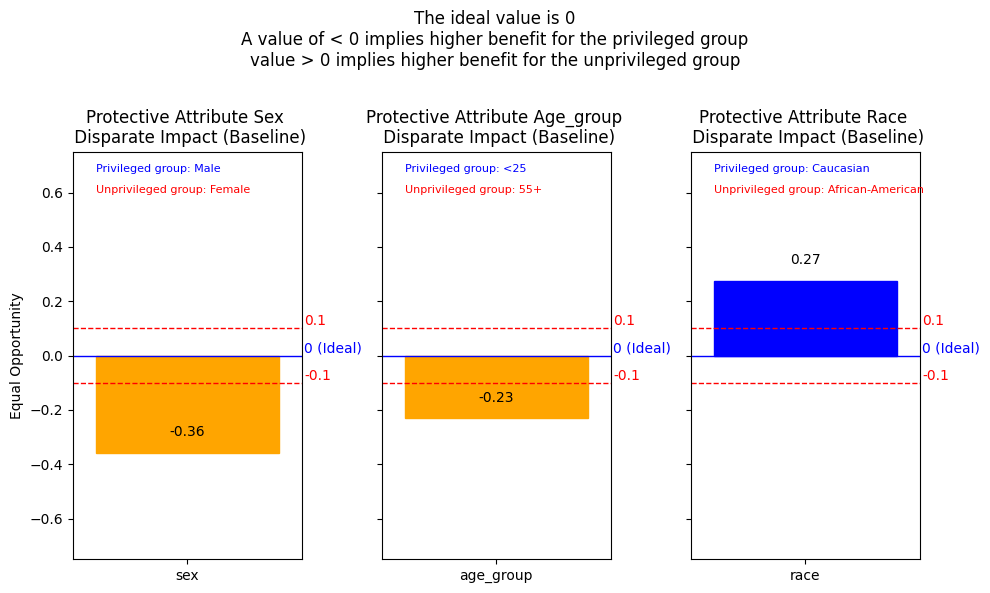

In [64]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 6), sharey=True)

plt.suptitle("The ideal value is 0\n"
             "A value of < 0 implies higher benefit for the privileged group\n"
             "value > 0 implies higher benefit for the unprivileged group\n",
             fontsize=12, ha='center')

# Iterate over each key ('age_group', 'race', 'sex')
for idx, key in enumerate(equal_opportunity_no_weights.keys()):
    impact_value = equal_opportunity_no_weights[key]

    # Plotting a single bar for each attribute
    bars = sns.barplot(ax=axs[idx], x=[key], y=[impact_value])

    # Color bars based on the value compared to 0.1 and -0.1
    if impact_value > -0.1 and impact_value < 0.1:
        bars.patches[0].set_color('green')    
    elif impact_value < -0.1:
        bars.patches[0].set_color('orange')  # Higher benefit for privileged group
    else:
        bars.patches[0].set_color('blue')  # Higher benefit for unprivileged group


    # Add value on top of each bar
    for bar in bars.patches:
        height = bar.get_height()
        axs[idx].text(bar.get_x() + bar.get_width() / 2.0, height + 0.05, f'{height:.2f}', ha='center', va='bottom', fontsize=10)

    axs[idx].set_ylabel('Equal Opportunity')
    axs[idx].set_title(f'Protective Attribute {key.capitalize()} \n Disparate Impact (Baseline)')

    # Draw lines for ideal value and thresholds
    axs[idx].axhline(0.1, color='red', linestyle='--', linewidth=1)
    axs[idx].axhline(-0.1, color='red', linestyle='--', linewidth=1)
    axs[idx].axhline(0, color='blue', linestyle='-', linewidth=1)  # Ideal value line
    
    # Annotate the lines
    axs[idx].text(0.51, 0.1, '0.1', color='red', ha='left', va='bottom')
    axs[idx].text(0.51, -0.1, '-0.1', color='red', ha='left', va='bottom')
    axs[idx].text(0.51, 0, '0 (Ideal)', color='blue', ha='left', va='bottom')

    # Add attribute-specific text
    if key == 'race':
        privileged_text = "Privileged group: Caucasian"
        unprivileged_text = "Unprivileged group: African-American"
    elif key == 'sex':
        privileged_text = "Privileged group: Male"
        unprivileged_text = "Unprivileged group: Female"
    elif key == 'age_group':
        privileged_text = "Privileged group: <25"
        unprivileged_text = "Unprivileged group: 55+"
    
    axs[idx].text(0.1, 0.95, privileged_text, transform=axs[idx].transAxes, horizontalalignment='left', fontsize=8, color='blue')
    axs[idx].text(0.1, 0.9, unprivileged_text, transform=axs[idx].transAxes, horizontalalignment='left', fontsize=8, color='red')

    axs[idx].set_ylim(-0.75, 0.75)  # Set y-axis limit for consistency

# Adjust layout and show plot
plt.tight_layout()
plt.show()

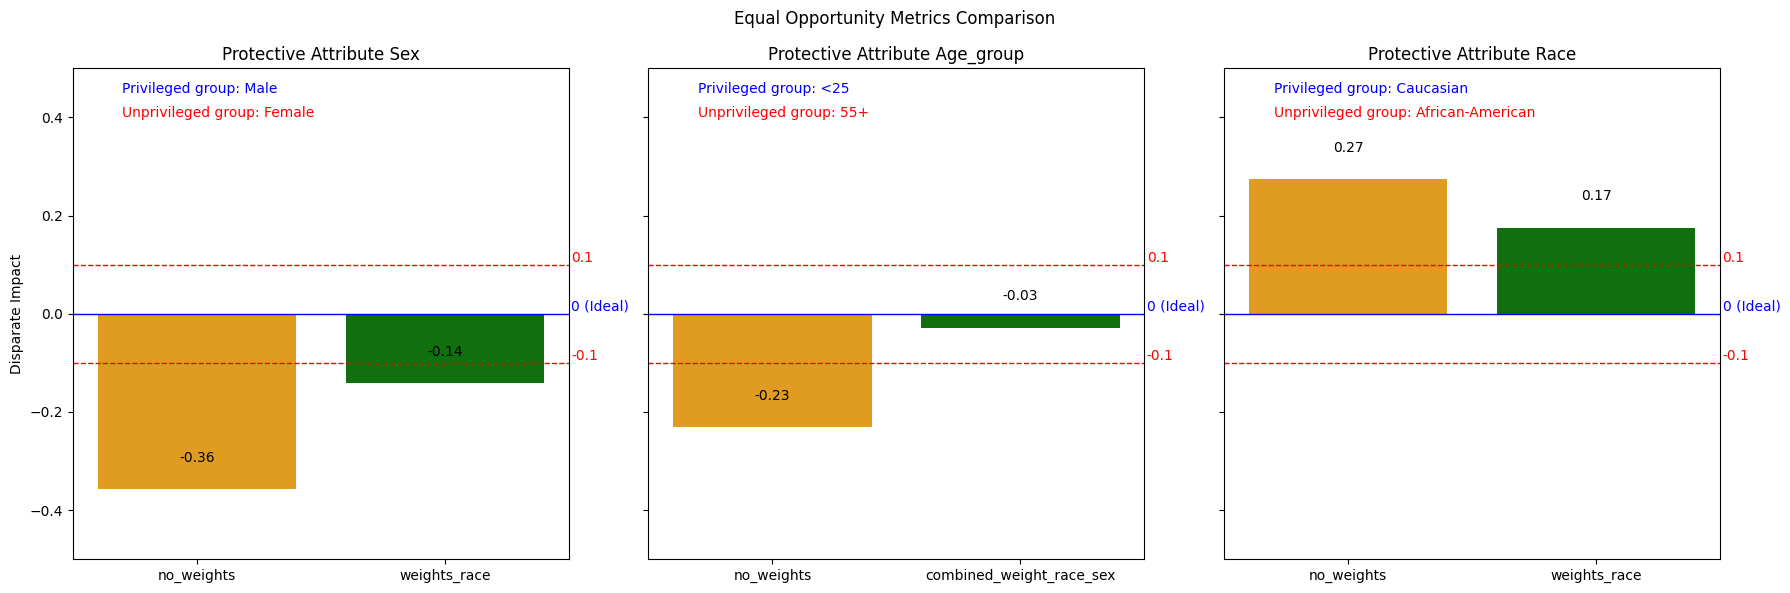

In [65]:
bets_values_for_equal_opportunity = {
    'sex': {
        'no_weights': equal_opportunity_no_weights['sex'],
        'weights_race': equal_opportunity_with_weights['sex']['weights_race'],
    },
    'age_group': {
        'no_weights': equal_opportunity_no_weights['age_group'],
        'combined_weight_race_sex': equal_opportunity_with_weights['age_group']['combined_weights_race_sex'],
    },
    'race': {
        'no_weights': equal_opportunity_no_weights['race'],
        'weights_race': equal_opportunity_with_weights['race']['weights_race'],
    }
}


# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

plt.suptitle("Equal Opportunity Metrics Comparison",
             fontsize=12, ha='center')

# Iterate over each attribute ('sex', 'age_group', 'race')
for idx, key in enumerate(bets_values_for_equal_opportunity.keys()):
    values_dict = bets_values_for_equal_opportunity[key]

    # Plotting bars for each value type
    bars = sns.barplot(ax=axs[idx], x=list(values_dict.keys()), y=list(values_dict.values()), palette=['orange', 'green'])

    # Add values on top of each bar
    for bar, value in zip(bars.patches, values_dict.values()):
        height = bar.get_height()
        axs[idx].text(bar.get_x() + bar.get_width() / 2.0, height + 0.05, f'{value:.2f}', ha='center', va='bottom', fontsize=10)

    axs[idx].set_ylabel('Disparate Impact')
    axs[idx].set_title(f'Protective Attribute {key.capitalize()}')

    # Draw lines for ideal value and thresholds
    axs[idx].axhline(0.1, color='red', linestyle='--', linewidth=1)
    axs[idx].axhline(-0.1, color='red', linestyle='--', linewidth=1)
    axs[idx].axhline(0, color='blue', linestyle='-', linewidth=1)  # Ideal value line
    
    # Annotate the lines
    axs[idx].text(1.51, 0.1, '0.1', color='red', ha='left', va='bottom')
    axs[idx].text(1.51, -0.1, '-0.1', color='red', ha='left', va='bottom')
    axs[idx].text(1.51, 0, '0 (Ideal)', color='blue', ha='left', va='bottom')

    # Add attribute-specific text
    if key == 'race':
        privileged_text = "Privileged group: Caucasian"
        unprivileged_text = "Unprivileged group: African-American"
    elif key == 'sex':
        privileged_text = "Privileged group: Male"
        unprivileged_text = "Unprivileged group: Female"
    elif key == 'age_group':
        privileged_text = "Privileged group: <25"
        unprivileged_text = "Unprivileged group: 55+"

    axs[idx].text(0.1, 0.95, privileged_text, transform=axs[idx].transAxes, ha='left', fontsize=10, color='blue')
    axs[idx].text(0.1, 0.9, unprivileged_text, transform=axs[idx].transAxes, ha='left', fontsize=10, color='red')

    axs[idx].set_ylim(-0.5, 0.5)  # Set y-axis limit for consistency

# Adjust layout and show plot
plt.tight_layout()
plt.show()